In [1]:
import torch

print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

12.8
NVIDIA GeForce RTX 4060 Laptop GPU


In [2]:
import torch

# Check and report VRAM usage
# torch.cuda.memory_allocated() gives the current tensor memory usage in bytes.
allocated_bytes = torch.cuda.memory_allocated('cuda')
allocated_mb = allocated_bytes / (1024 * 1024)

reserved_bytes = torch.cuda.memory_reserved('cuda')
reserved_mb = reserved_bytes / (1024 * 1024)

print("\n--- VRAM USAGE REPORT ---")
print(f"Memory Allocated: {allocated_mb:.2f} MB")
print(f"Memory Reserved:  {reserved_mb:.2f} MB")
print("-------------------------\n")
#


--- VRAM USAGE REPORT ---
Memory Allocated: 0.00 MB
Memory Reserved:  0.00 MB
-------------------------



In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

training_pipeline = A.Compose([
    A.Resize(height=224, width=224),
    A.SquareSymmetry(p=0.5),
    A.RandomCrop(height=180, width=180,  p=1.0),
    A.Resize(height=224, width=224),
    A.RandomRain(slant_range=(-15,15), drop_length=15, drop_width=1, rain_type="default", blur_value=7 ,p=0.3),
    A.RandomBrightnessContrast(brightness_limit=(-0.3, 0.3), contrast_limit=(-0.2, 0.2), p=0.3),
    A.Rotate(limit=45, p=0.4),
    A.GaussNoise(std_range=(0.1, 0.2), per_channel=True  ,p=0.3),
    A.ColorJitter(brightness=(0.8, 1.1), contrast=(0.8, 1.1), saturation=(0.8, 1.1), hue=(-0.5, 0.5)),
    A.OneOf([
        A.CoarseDropout(num_holes_range=(1, 8), hole_height_range=(0.1, 0.25),
                        hole_width_range=(0.1, 0.25), fill=0, p=0.3),
        A.GridDropout(ratio=0.5, random_offset=True,  p=0.3)
    ]),
    A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

validation_pipeline = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [4]:
import cv2
from torchvision import datasets

class CustomDataset(datasets.ImageFolder):

    def __getitem__(self, index):

        path, target = self.samples[index]

        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, target

    def __len__(self):
        return len(self.samples)

In [5]:
import torchvision.models as models
import torch.nn as nn

class PestClassifierMobileNetV2(nn.Module):

    def __init__(self, num_classes):
        super(PestClassifierMobileNetV2, self).__init__()

        # get model
        self.base_model = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V2')

        # Froze feature extraction layer to retain weights.
        for params in self.base_model.parameters():
            params.requires_grad = False

        # get number of features
        num_filters = self.base_model.classifier[1].in_features

        # Hyperparameter tuning: new layer for 6 rice pests.
        self.base_model.classifier[1] = nn.Linear(num_filters, num_classes)

    # Forward propagation
    def forward(self, x):

       features = self.base_model.features(x)

       features = F.adaptive_avg_pool2d(features, output_size=(1, 1)).reshape(features.shape[0], -1)

       features = self.base_model.classifier(features)

       return features

    def unfreeze_last_block(self):

        print("\nUnfreezing last block of feature extraction.")

        for param in self.base_model.features[-1].parameters():
            param.requires_grad = True



In [12]:
import torch
from tqdm import tqdm

def train_and_test(model, optimizer, criterion, train_dataloader, test_dataloader, num_epoch, device):
    train_losses = []
    test_losses = []
    accuracies = []
    best_accuracy = 0.0

    for epoch in range(num_epoch):
        # --- TRAINING PHASE ---
        model.train()
        running_train_loss = 0.0
        train_pbar = tqdm(train_dataloader, desc=f"Train epoch: {epoch+1}")
        for data, labels in train_pbar:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        training_loss = running_train_loss / len(train_dataloader)
        train_losses.append(training_loss)

        # --- TESTING PHASE ---
        model.eval()
        running_test_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        with torch.no_grad():
            for inputs, labels in tqdm(test_dataloader, desc=f"Test epoch: {epoch+1}"):
                inputs, labels = inputs.to(device), labels.to(device)

                output_loss = model(inputs)
                loss = criterion(output_loss, labels)
                running_test_loss += loss.item()
                _, predicted = torch.max(output_loss.data, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

        testing_loss = running_test_loss / len(test_dataloader)
        test_losses.append(testing_loss)
        accuracy = 100 * correct_predictions / total_samples
        accuracies.append(accuracy)

        epoch_summary = f'Epoch {epoch+1}/{num_epoch} | Train Loss: {training_loss:.4f} | Test Loss: {testing_loss:.4f} | Accuracy: {accuracy:.2f}%'

        if device.type == 'cuda':
            allocated_gb = torch.cuda.memory_allocated() / (1024 ** 3)
            reserved_gb = torch.cuda.memory_reserved() / (1024 ** 3)
            epoch_summary += f' | GPU Memory (Alloc/Reserved): {allocated_gb:.2f}/{reserved_gb:.3f} GB'

        tqdm.write(epoch_summary)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), 'models/SMobileNetV3_rice_pest_classificationV2pth')

    tqdm.write('Training done!')

    return {'train_loss': train_losses, 'test_loss': test_losses, 'accuracy': accuracies}, best_accuracy

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_training_result(*results):

    full_train_loss = []
    full_test_loss = []

    for res in results:
        full_train_loss.extend(res.get('train_loss', []))
        full_test_loss.extend(res.get('test_loss', []))

    total_epochs = len(full_train_loss)
    if total_epochs == 0:
        print("No data to plot.")
        return

    epochs = range(1, total_epochs + 1)

    data = {
        'Epoch': epochs,
        'Training Loss': full_train_loss,
        'Testing Loss': full_test_loss,
    }

    df = pd.DataFrame(data)

    df_long = df.melt(id_vars=['Epoch'], var_name='Loss Type', value_name='Loss')

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_long, x='Epoch', y='Loss', hue='Loss Type', marker='o')

    plt.title('Training and Testing Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_accuracy(*results):

    full_accuracy = []

    for result in results:
        accuracy = result.get('accuracy', [])
        full_accuracy.extend(accuracy)

    total_epochs = len(full_accuracy)
    if total_epochs == 0:
        print("No accuracy data to plot.")
        return

    epochs = range(1, total_epochs + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, full_accuracy, label='Accuracy', marker='o', color='g')

    plt.title('Accuracy Evaluation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()


def save_historical_data(*histories):

    full_train_loss = []
    full_test_loss = []
    full_accuracy = []

    for history in histories:

        full_train_loss.extend(history.get('train_loss', []))
        full_test_loss.extend(history.get('test_loss', []))
        full_accuracy.extend(history.get('accuracy', []))

    total_epochs = len(full_train_loss)

    data_dict = {
        'epoch': total_epochs,
        'train_loss': full_train_loss,
        'test_loss': full_test_loss,
        'accuracy': full_accuracy,
    }

    history_df = pd.DataFrame(data_dict)
    history_df.to_csv('training_history_standard.csv', index=False)

    print("Historical data saved successfully!")

# def save_single_data(data):

# sample_test_accuracies = np.linspace(0.60, 0.95, 20) - np.random.rand(20) * 0.08
# plot_accuracy(accuracy=sample_test_accuracies)


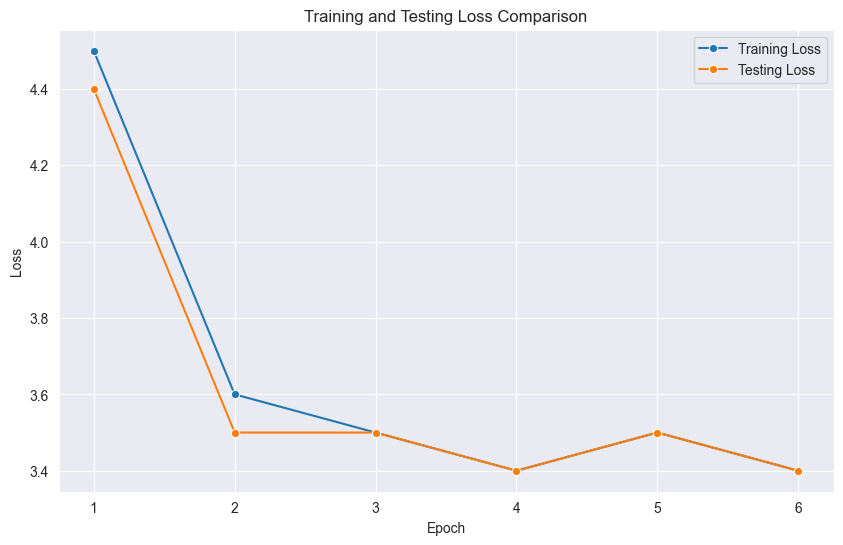

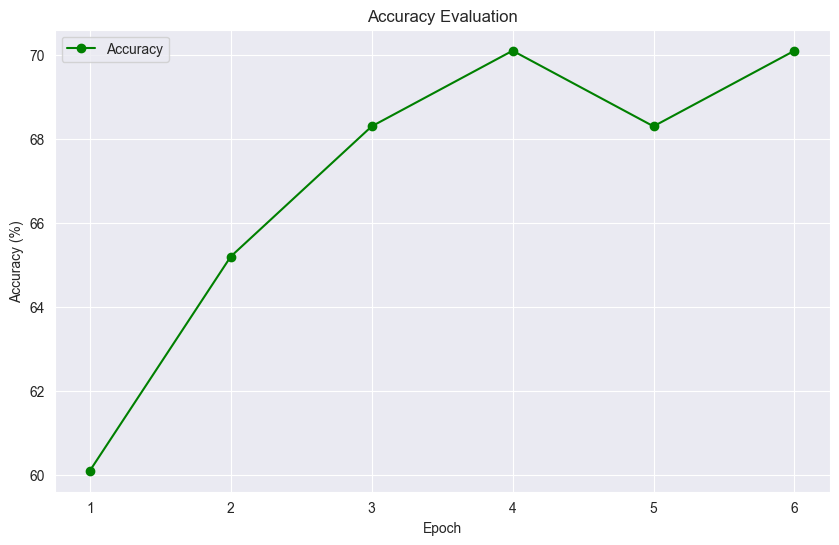

In [8]:
# --- Example of how to call the new dynamic functions ---

# You would have these history dictionaries from your training stages
history1 = {'train_loss': [4.5, 3.6], 'test_loss': [4.4, 3.5], 'accuracy': [60.1, 65.2]}
history2 = {'train_loss': [3.5, 3.4], 'test_loss': [3.5, 3.4], 'accuracy': [68.3, 70.1]}
history3 = {'train_loss': [2.7, 2.6], 'test_loss': [2.1, 2.4], 'accuracy': [74.3, 78.1]}

# You can now call the functions with any number of histories
plot_training_result(history1, history2, history2)
plot_accuracy(history1, history2, history2)

In [67]:
num = [1,2,3,4,5,6]

print(num[:-1])

for i, num_len in enumerate(num[:-1]):
    print(num_len)

[1, 2, 3, 4, 5]
1
2
3
4
5


In [9]:
from torch.utils.data import DataLoader

train_set = CustomDataset(root='datasets/train', transform=training_pipeline)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_set = CustomDataset(root='datasets/test', transform=validation_pipeline)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

classes = train_set.classes

Test epoch: 1: 100%|██████████| 34/34 [00:06<00:00,  5.59it/s]


Epoch 1/64 | Train Loss: 1.6953 | Test Loss: 1.5965 | Accuracy: 35.04% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 2: 100%|██████████| 34/34 [00:04<00:00,  7.05it/s]


Epoch 2/64 | Train Loss: 1.6067 | Test Loss: 1.5186 | Accuracy: 46.58% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 3: 100%|██████████| 34/34 [00:04<00:00,  7.11it/s]


Epoch 3/64 | Train Loss: 1.5679 | Test Loss: 1.4636 | Accuracy: 52.02% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 4: 100%|██████████| 34/34 [00:04<00:00,  6.87it/s]


Epoch 4/64 | Train Loss: 1.5369 | Test Loss: 1.4082 | Accuracy: 56.05% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 5: 100%|██████████| 34/34 [00:04<00:00,  7.05it/s]


Epoch 5/64 | Train Loss: 1.5124 | Test Loss: 1.3640 | Accuracy: 58.26% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 6: 100%|██████████| 34/34 [00:04<00:00,  7.08it/s]


Epoch 6/64 | Train Loss: 1.4849 | Test Loss: 1.3257 | Accuracy: 60.88% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 7: 100%|██████████| 34/34 [00:04<00:00,  7.03it/s]


Epoch 7/64 | Train Loss: 1.4722 | Test Loss: 1.2890 | Accuracy: 62.29% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 8: 100%|██████████| 34/34 [00:04<00:00,  7.10it/s]


Epoch 8/64 | Train Loss: 1.4489 | Test Loss: 1.2591 | Accuracy: 63.13% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 9: 100%|██████████| 34/34 [00:04<00:00,  7.10it/s]


Epoch 9/64 | Train Loss: 1.4317 | Test Loss: 1.2304 | Accuracy: 64.26% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 10: 100%|██████████| 34/34 [00:04<00:00,  7.11it/s]


Epoch 10/64 | Train Loss: 1.4271 | Test Loss: 1.2097 | Accuracy: 65.20% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 11: 100%|██████████| 34/34 [00:04<00:00,  6.99it/s]


Epoch 11/64 | Train Loss: 1.4039 | Test Loss: 1.1769 | Accuracy: 65.24% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 12: 100%|██████████| 34/34 [00:04<00:00,  7.08it/s]


Epoch 12/64 | Train Loss: 1.3928 | Test Loss: 1.1590 | Accuracy: 66.46% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 13: 100%|██████████| 34/34 [00:04<00:00,  7.00it/s]


Epoch 13/64 | Train Loss: 1.3834 | Test Loss: 1.1309 | Accuracy: 66.98% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 14: 100%|██████████| 34/34 [00:04<00:00,  7.13it/s]


Epoch 14/64 | Train Loss: 1.3629 | Test Loss: 1.1164 | Accuracy: 67.35% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 15: 100%|██████████| 34/34 [00:04<00:00,  7.05it/s]


Epoch 15/64 | Train Loss: 1.3668 | Test Loss: 1.1071 | Accuracy: 68.20% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 16: 100%|██████████| 34/34 [00:04<00:00,  7.07it/s]


Epoch 16/64 | Train Loss: 1.3551 | Test Loss: 1.0810 | Accuracy: 68.43% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 17: 100%|██████████| 34/34 [00:04<00:00,  7.11it/s]


Epoch 17/64 | Train Loss: 1.3486 | Test Loss: 1.0698 | Accuracy: 69.18% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 18: 100%|██████████| 34/34 [00:04<00:00,  7.05it/s]


Epoch 18/64 | Train Loss: 1.3431 | Test Loss: 1.0573 | Accuracy: 69.23% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 19: 100%|██████████| 34/34 [00:04<00:00,  7.08it/s]


Epoch 19/64 | Train Loss: 1.3395 | Test Loss: 1.0437 | Accuracy: 70.08% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 20: 100%|██████████| 34/34 [00:04<00:00,  7.15it/s]


Epoch 20/64 | Train Loss: 1.3281 | Test Loss: 1.0352 | Accuracy: 70.03% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 21: 100%|██████████| 34/34 [00:04<00:00,  7.09it/s]


Epoch 21/64 | Train Loss: 1.3210 | Test Loss: 1.0184 | Accuracy: 70.73% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 22: 100%|██████████| 34/34 [00:04<00:00,  7.02it/s]


Epoch 22/64 | Train Loss: 1.3076 | Test Loss: 1.0040 | Accuracy: 71.11% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 23: 100%|██████████| 34/34 [00:04<00:00,  7.05it/s]


Epoch 23/64 | Train Loss: 1.3094 | Test Loss: 1.0056 | Accuracy: 71.06% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 24: 100%|██████████| 34/34 [00:04<00:00,  7.09it/s]


Epoch 24/64 | Train Loss: 1.3060 | Test Loss: 0.9819 | Accuracy: 71.72% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 25: 100%|██████████| 34/34 [00:04<00:00,  7.02it/s]


Epoch 25/64 | Train Loss: 1.3025 | Test Loss: 0.9702 | Accuracy: 72.33% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 26: 100%|██████████| 34/34 [00:04<00:00,  7.05it/s]


Epoch 26/64 | Train Loss: 1.2990 | Test Loss: 0.9686 | Accuracy: 72.42% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 27: 100%|██████████| 34/34 [00:04<00:00,  7.08it/s]


Epoch 27/64 | Train Loss: 1.2917 | Test Loss: 0.9592 | Accuracy: 72.70% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 28: 100%|██████████| 34/34 [00:04<00:00,  7.10it/s]


Epoch 28/64 | Train Loss: 1.2866 | Test Loss: 0.9470 | Accuracy: 73.31% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 29: 100%|██████████| 34/34 [00:04<00:00,  7.02it/s]


Epoch 29/64 | Train Loss: 1.2882 | Test Loss: 0.9373 | Accuracy: 72.98% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 30: 100%|██████████| 34/34 [00:04<00:00,  7.12it/s]


Epoch 30/64 | Train Loss: 1.2732 | Test Loss: 0.9214 | Accuracy: 73.59% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 31: 100%|██████████| 34/34 [00:04<00:00,  7.11it/s]


Epoch 31/64 | Train Loss: 1.2650 | Test Loss: 0.9258 | Accuracy: 73.83% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 32: 100%|██████████| 34/34 [00:04<00:00,  7.08it/s]


Epoch 32/64 | Train Loss: 1.2577 | Test Loss: 0.9173 | Accuracy: 74.39% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 33: 100%|██████████| 34/34 [00:04<00:00,  7.09it/s]


Epoch 33/64 | Train Loss: 1.2682 | Test Loss: 0.9039 | Accuracy: 74.39% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 34: 100%|██████████| 34/34 [00:04<00:00,  7.08it/s]


Epoch 34/64 | Train Loss: 1.2627 | Test Loss: 0.9132 | Accuracy: 74.34% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 35: 100%|██████████| 34/34 [00:04<00:00,  7.11it/s]


Epoch 35/64 | Train Loss: 1.2565 | Test Loss: 0.8937 | Accuracy: 74.67% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 36: 100%|██████████| 34/34 [00:04<00:00,  7.04it/s]


Epoch 36/64 | Train Loss: 1.2572 | Test Loss: 0.8824 | Accuracy: 74.86% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 37: 100%|██████████| 34/34 [00:04<00:00,  7.01it/s]


Epoch 37/64 | Train Loss: 1.2467 | Test Loss: 0.8892 | Accuracy: 74.25% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 38: 100%|██████████| 34/34 [00:04<00:00,  7.01it/s]


Epoch 38/64 | Train Loss: 1.2416 | Test Loss: 0.8677 | Accuracy: 75.33% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 39: 100%|██████████| 34/34 [00:04<00:00,  7.08it/s]


Epoch 39/64 | Train Loss: 1.2427 | Test Loss: 0.8655 | Accuracy: 75.19% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 40: 100%|██████████| 34/34 [00:04<00:00,  7.15it/s]


Epoch 40/64 | Train Loss: 1.2470 | Test Loss: 0.8610 | Accuracy: 75.75% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 41: 100%|██████████| 34/34 [00:04<00:00,  7.16it/s]


Epoch 41/64 | Train Loss: 1.2379 | Test Loss: 0.8631 | Accuracy: 75.14% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 42: 100%|██████████| 34/34 [00:04<00:00,  7.08it/s]


Epoch 42/64 | Train Loss: 1.2375 | Test Loss: 0.8555 | Accuracy: 75.70% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 43: 100%|██████████| 34/34 [00:04<00:00,  7.07it/s]


Epoch 43/64 | Train Loss: 1.2458 | Test Loss: 0.8499 | Accuracy: 75.70% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 44: 100%|██████████| 34/34 [00:04<00:00,  6.98it/s]


Epoch 44/64 | Train Loss: 1.2303 | Test Loss: 0.8443 | Accuracy: 76.31% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 45: 100%|██████████| 34/34 [00:04<00:00,  7.01it/s]


Epoch 45/64 | Train Loss: 1.2318 | Test Loss: 0.8427 | Accuracy: 76.08% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 46: 100%|██████████| 34/34 [00:04<00:00,  7.07it/s]


Epoch 46/64 | Train Loss: 1.2361 | Test Loss: 0.8383 | Accuracy: 76.31% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 47: 100%|██████████| 34/34 [00:04<00:00,  7.04it/s]


Epoch 47/64 | Train Loss: 1.2384 | Test Loss: 0.8306 | Accuracy: 76.45% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 48: 100%|██████████| 34/34 [00:04<00:00,  7.10it/s]


Epoch 48/64 | Train Loss: 1.2161 | Test Loss: 0.8296 | Accuracy: 76.78% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 49: 100%|██████████| 34/34 [00:06<00:00,  5.49it/s]


Epoch 49/64 | Train Loss: 1.2153 | Test Loss: 0.8222 | Accuracy: 76.69% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 50: 100%|██████████| 34/34 [00:04<00:00,  7.09it/s]


Epoch 50/64 | Train Loss: 1.2222 | Test Loss: 0.8257 | Accuracy: 76.78% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 51: 100%|██████████| 34/34 [00:04<00:00,  7.06it/s]


Epoch 51/64 | Train Loss: 1.2255 | Test Loss: 0.8173 | Accuracy: 77.02% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 52: 100%|██████████| 34/34 [00:04<00:00,  7.02it/s]


Epoch 52/64 | Train Loss: 1.2173 | Test Loss: 0.8158 | Accuracy: 77.39% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 53: 100%|██████████| 34/34 [00:04<00:00,  6.94it/s]


Epoch 53/64 | Train Loss: 1.2221 | Test Loss: 0.8134 | Accuracy: 77.35% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 54: 100%|██████████| 34/34 [00:04<00:00,  7.14it/s]


Epoch 54/64 | Train Loss: 1.2093 | Test Loss: 0.8110 | Accuracy: 76.92% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 55: 100%|██████████| 34/34 [00:04<00:00,  7.15it/s]


Epoch 55/64 | Train Loss: 1.2080 | Test Loss: 0.8045 | Accuracy: 77.06% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 56: 100%|██████████| 34/34 [00:04<00:00,  6.98it/s]


Epoch 56/64 | Train Loss: 1.2168 | Test Loss: 0.8064 | Accuracy: 77.06% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 57: 100%|██████████| 34/34 [00:04<00:00,  7.04it/s]


Epoch 57/64 | Train Loss: 1.2125 | Test Loss: 0.7902 | Accuracy: 77.58% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 58: 100%|██████████| 34/34 [00:04<00:00,  7.07it/s]


Epoch 58/64 | Train Loss: 1.2113 | Test Loss: 0.7873 | Accuracy: 77.58% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 59: 100%|██████████| 34/34 [00:04<00:00,  7.03it/s]


Epoch 59/64 | Train Loss: 1.2051 | Test Loss: 0.7963 | Accuracy: 77.02% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 60: 100%|██████████| 34/34 [00:04<00:00,  7.10it/s]


Epoch 60/64 | Train Loss: 1.1996 | Test Loss: 0.7811 | Accuracy: 77.49% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 61: 100%|██████████| 34/34 [00:04<00:00,  7.05it/s]


Epoch 61/64 | Train Loss: 1.2034 | Test Loss: 0.7824 | Accuracy: 78.05% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 62: 100%|██████████| 34/34 [00:04<00:00,  7.06it/s]


Epoch 62/64 | Train Loss: 1.1966 | Test Loss: 0.7822 | Accuracy: 77.86% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 63: 100%|██████████| 34/34 [00:04<00:00,  7.07it/s]


Epoch 63/64 | Train Loss: 1.1967 | Test Loss: 0.7895 | Accuracy: 77.63% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 64: 100%|██████████| 34/34 [00:04<00:00,  7.11it/s]


Epoch 64/64 | Train Loss: 1.2012 | Test Loss: 0.7697 | Accuracy: 78.24% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB
Training done!

Unfreezing last block of feature extraction.

Phase 2 Training



Test epoch: 1: 100%|██████████| 34/34 [00:04<00:00,  7.08it/s]


Epoch 1/64 | Train Loss: 1.2108 | Test Loss: 0.7760 | Accuracy: 77.53% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 2: 100%|██████████| 34/34 [00:04<00:00,  7.13it/s]


Epoch 2/64 | Train Loss: 1.2011 | Test Loss: 0.7792 | Accuracy: 78.00% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 3: 100%|██████████| 34/34 [00:04<00:00,  7.07it/s]


Epoch 3/64 | Train Loss: 1.1820 | Test Loss: 0.7660 | Accuracy: 78.38% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 4: 100%|██████████| 34/34 [00:04<00:00,  6.98it/s]


Epoch 4/64 | Train Loss: 1.1914 | Test Loss: 0.7622 | Accuracy: 78.10% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 5: 100%|██████████| 34/34 [00:04<00:00,  6.93it/s]


Epoch 5/64 | Train Loss: 1.1834 | Test Loss: 0.7755 | Accuracy: 78.00% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 6: 100%|██████████| 34/34 [00:04<00:00,  7.08it/s]


Epoch 6/64 | Train Loss: 1.1880 | Test Loss: 0.7606 | Accuracy: 78.24% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 7: 100%|██████████| 34/34 [00:04<00:00,  7.07it/s]


Epoch 7/64 | Train Loss: 1.1974 | Test Loss: 0.7732 | Accuracy: 78.05% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 8: 100%|██████████| 34/34 [00:04<00:00,  7.13it/s]


Epoch 8/64 | Train Loss: 1.2025 | Test Loss: 0.7593 | Accuracy: 78.24% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 9: 100%|██████████| 34/34 [00:04<00:00,  6.92it/s]


Epoch 9/64 | Train Loss: 1.2036 | Test Loss: 0.7570 | Accuracy: 78.14% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 10: 100%|██████████| 34/34 [00:04<00:00,  6.95it/s]


Epoch 10/64 | Train Loss: 1.1882 | Test Loss: 0.7589 | Accuracy: 78.10% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 11: 100%|██████████| 34/34 [00:04<00:00,  6.86it/s]


Epoch 11/64 | Train Loss: 1.1814 | Test Loss: 0.7492 | Accuracy: 78.52% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 12: 100%|██████████| 34/34 [00:04<00:00,  6.97it/s]


Epoch 12/64 | Train Loss: 1.1762 | Test Loss: 0.7519 | Accuracy: 78.33% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 13: 100%|██████████| 34/34 [00:04<00:00,  7.06it/s]


Epoch 13/64 | Train Loss: 1.1832 | Test Loss: 0.7520 | Accuracy: 78.66% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 14: 100%|██████████| 34/34 [00:11<00:00,  2.88it/s]


Epoch 14/64 | Train Loss: 1.1946 | Test Loss: 0.7438 | Accuracy: 78.56% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 15: 100%|██████████| 34/34 [00:11<00:00,  2.90it/s]


Epoch 15/64 | Train Loss: 1.1885 | Test Loss: 0.7379 | Accuracy: 78.52% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 16: 100%|██████████| 34/34 [00:18<00:00,  1.89it/s]


Epoch 16/64 | Train Loss: 1.1837 | Test Loss: 0.7409 | Accuracy: 78.47% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 17: 100%|██████████| 34/34 [00:13<00:00,  2.61it/s]


Epoch 17/64 | Train Loss: 1.1811 | Test Loss: 0.7402 | Accuracy: 78.56% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 18: 100%|██████████| 34/34 [00:13<00:00,  2.61it/s]


Epoch 18/64 | Train Loss: 1.1765 | Test Loss: 0.7385 | Accuracy: 78.56% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 19: 100%|██████████| 34/34 [00:08<00:00,  4.10it/s]


Epoch 19/64 | Train Loss: 1.1915 | Test Loss: 0.7324 | Accuracy: 79.13% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 20: 100%|██████████| 34/34 [00:05<00:00,  6.54it/s]


Epoch 20/64 | Train Loss: 1.1865 | Test Loss: 0.7423 | Accuracy: 78.52% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 21: 100%|██████████| 34/34 [00:07<00:00,  4.77it/s]


Epoch 21/64 | Train Loss: 1.1786 | Test Loss: 0.7347 | Accuracy: 79.17% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 22: 100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch 22/64 | Train Loss: 1.1771 | Test Loss: 0.7333 | Accuracy: 78.85% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 23: 100%|██████████| 34/34 [00:06<00:00,  5.36it/s]


Epoch 23/64 | Train Loss: 1.1762 | Test Loss: 0.7196 | Accuracy: 79.27% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 24: 100%|██████████| 34/34 [00:05<00:00,  5.80it/s]


Epoch 24/64 | Train Loss: 1.1832 | Test Loss: 0.7317 | Accuracy: 79.08% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 25: 100%|██████████| 34/34 [00:05<00:00,  6.13it/s]


Epoch 25/64 | Train Loss: 1.1732 | Test Loss: 0.7206 | Accuracy: 79.32% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 26: 100%|██████████| 34/34 [00:05<00:00,  6.07it/s]


Epoch 26/64 | Train Loss: 1.1775 | Test Loss: 0.7197 | Accuracy: 79.27% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 27: 100%|██████████| 34/34 [00:05<00:00,  6.27it/s]


Epoch 27/64 | Train Loss: 1.1682 | Test Loss: 0.7265 | Accuracy: 79.08% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 28: 100%|██████████| 34/34 [00:05<00:00,  6.21it/s]


Epoch 28/64 | Train Loss: 1.1787 | Test Loss: 0.7291 | Accuracy: 79.08% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 29: 100%|██████████| 34/34 [00:05<00:00,  5.68it/s]


Epoch 29/64 | Train Loss: 1.1871 | Test Loss: 0.7301 | Accuracy: 79.27% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 30: 100%|██████████| 34/34 [00:06<00:00,  5.24it/s]


Epoch 30/64 | Train Loss: 1.1761 | Test Loss: 0.7277 | Accuracy: 79.41% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 31: 100%|██████████| 34/34 [00:05<00:00,  6.19it/s]


Epoch 31/64 | Train Loss: 1.1785 | Test Loss: 0.7209 | Accuracy: 79.08% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 32: 100%|██████████| 34/34 [00:05<00:00,  6.15it/s]


Epoch 32/64 | Train Loss: 1.1770 | Test Loss: 0.7219 | Accuracy: 79.32% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 33: 100%|██████████| 34/34 [00:05<00:00,  5.92it/s]


Epoch 33/64 | Train Loss: 1.1680 | Test Loss: 0.7129 | Accuracy: 79.41% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 34: 100%|██████████| 34/34 [00:05<00:00,  5.75it/s]


Epoch 34/64 | Train Loss: 1.1730 | Test Loss: 0.7199 | Accuracy: 79.36% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 35: 100%|██████████| 34/34 [00:05<00:00,  6.39it/s]


Epoch 35/64 | Train Loss: 1.1749 | Test Loss: 0.7156 | Accuracy: 79.64% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 36: 100%|██████████| 34/34 [00:06<00:00,  5.50it/s]


Epoch 36/64 | Train Loss: 1.1733 | Test Loss: 0.7137 | Accuracy: 79.46% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 37: 100%|██████████| 34/34 [00:05<00:00,  6.14it/s]


Epoch 37/64 | Train Loss: 1.1698 | Test Loss: 0.7047 | Accuracy: 79.69% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 38: 100%|██████████| 34/34 [00:05<00:00,  6.60it/s]


Epoch 38/64 | Train Loss: 1.1722 | Test Loss: 0.7103 | Accuracy: 78.94% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 39: 100%|██████████| 34/34 [00:05<00:00,  6.45it/s]


Epoch 39/64 | Train Loss: 1.1668 | Test Loss: 0.7114 | Accuracy: 80.16% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 40: 100%|██████████| 34/34 [00:05<00:00,  6.55it/s]


Epoch 40/64 | Train Loss: 1.1600 | Test Loss: 0.7104 | Accuracy: 79.46% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 41: 100%|██████████| 34/34 [00:07<00:00,  4.33it/s]


Epoch 41/64 | Train Loss: 1.1696 | Test Loss: 0.7130 | Accuracy: 79.22% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 42: 100%|██████████| 34/34 [00:07<00:00,  4.28it/s]


Epoch 42/64 | Train Loss: 1.1568 | Test Loss: 0.7048 | Accuracy: 79.50% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 43: 100%|██████████| 34/34 [00:10<00:00,  3.26it/s]


Epoch 43/64 | Train Loss: 1.1617 | Test Loss: 0.7102 | Accuracy: 79.69% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 44: 100%|██████████| 34/34 [00:12<00:00,  2.75it/s]


Epoch 44/64 | Train Loss: 1.1709 | Test Loss: 0.7086 | Accuracy: 79.92% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 45: 100%|██████████| 34/34 [00:12<00:00,  2.66it/s]


Epoch 45/64 | Train Loss: 1.1611 | Test Loss: 0.7057 | Accuracy: 80.02% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 46: 100%|██████████| 34/34 [00:46<00:00,  1.37s/it]


Epoch 46/64 | Train Loss: 1.1656 | Test Loss: 0.7051 | Accuracy: 79.74% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 47: 100%|██████████| 34/34 [00:11<00:00,  2.87it/s]


Epoch 47/64 | Train Loss: 1.1671 | Test Loss: 0.7049 | Accuracy: 79.60% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 48: 100%|██████████| 34/34 [00:04<00:00,  7.03it/s]


Epoch 48/64 | Train Loss: 1.1698 | Test Loss: 0.7006 | Accuracy: 79.55% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 49: 100%|██████████| 34/34 [00:04<00:00,  6.84it/s]


Epoch 49/64 | Train Loss: 1.1524 | Test Loss: 0.7018 | Accuracy: 79.69% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 50: 100%|██████████| 34/34 [00:04<00:00,  7.07it/s]


Epoch 50/64 | Train Loss: 1.1645 | Test Loss: 0.6879 | Accuracy: 79.97% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 51: 100%|██████████| 34/34 [00:04<00:00,  7.13it/s]


Epoch 51/64 | Train Loss: 1.1695 | Test Loss: 0.6979 | Accuracy: 79.97% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 52: 100%|██████████| 34/34 [00:11<00:00,  2.88it/s]


Epoch 52/64 | Train Loss: 1.1765 | Test Loss: 0.6885 | Accuracy: 80.25% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 53: 100%|██████████| 34/34 [00:04<00:00,  7.04it/s]


Epoch 53/64 | Train Loss: 1.1602 | Test Loss: 0.6945 | Accuracy: 79.83% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 54: 100%|██████████| 34/34 [00:04<00:00,  7.03it/s]


Epoch 54/64 | Train Loss: 1.1516 | Test Loss: 0.6902 | Accuracy: 80.02% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 55: 100%|██████████| 34/34 [00:04<00:00,  6.84it/s]


Epoch 55/64 | Train Loss: 1.1514 | Test Loss: 0.6829 | Accuracy: 80.30% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 56: 100%|██████████| 34/34 [00:04<00:00,  7.05it/s]


Epoch 56/64 | Train Loss: 1.1476 | Test Loss: 0.6857 | Accuracy: 79.92% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 57: 100%|██████████| 34/34 [00:04<00:00,  7.13it/s]


Epoch 57/64 | Train Loss: 1.1730 | Test Loss: 0.6837 | Accuracy: 79.60% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 58: 100%|██████████| 34/34 [00:13<00:00,  2.45it/s]


Epoch 58/64 | Train Loss: 1.1534 | Test Loss: 0.6907 | Accuracy: 79.92% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 59: 100%|██████████| 34/34 [00:11<00:00,  3.05it/s]


Epoch 59/64 | Train Loss: 1.1685 | Test Loss: 0.6823 | Accuracy: 79.88% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 60: 100%|██████████| 34/34 [00:04<00:00,  7.12it/s]


Epoch 60/64 | Train Loss: 1.1663 | Test Loss: 0.6877 | Accuracy: 79.92% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 61: 100%|██████████| 34/34 [00:04<00:00,  7.13it/s]


Epoch 61/64 | Train Loss: 1.1586 | Test Loss: 0.6903 | Accuracy: 80.07% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 62: 100%|██████████| 34/34 [00:04<00:00,  7.19it/s]


Epoch 62/64 | Train Loss: 1.1531 | Test Loss: 0.6806 | Accuracy: 80.07% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 63: 100%|██████████| 34/34 [00:04<00:00,  7.18it/s]


Epoch 63/64 | Train Loss: 1.1645 | Test Loss: 0.6948 | Accuracy: 80.02% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 64: 100%|██████████| 34/34 [00:04<00:00,  7.00it/s]


Epoch 64/64 | Train Loss: 1.1584 | Test Loss: 0.6827 | Accuracy: 80.11% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB
Training done!


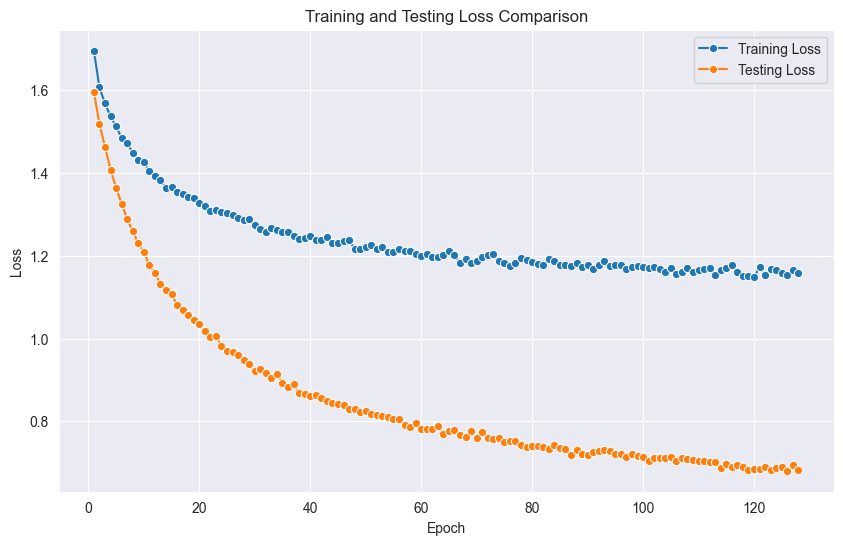

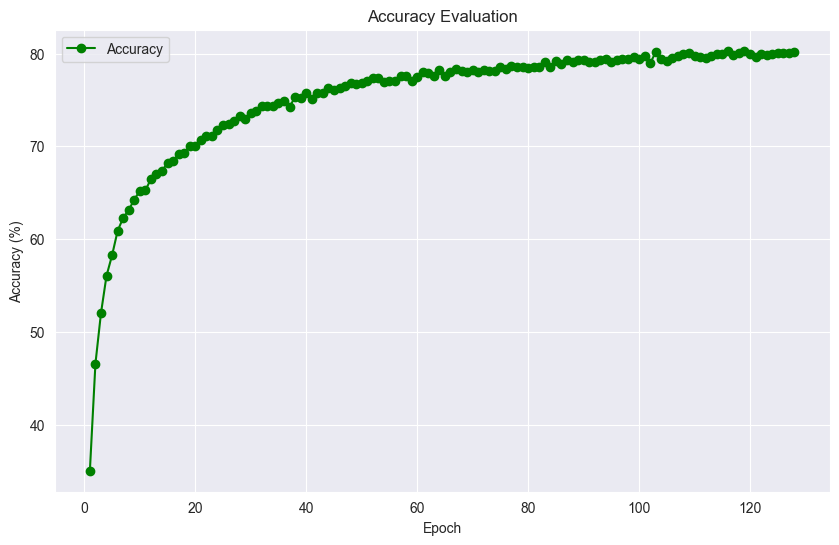

Historical data saved successfully!


In [13]:
import torch.optim as optim

hardware = torch.device('cuda' if   torch.cuda.is_available() else 'cpu')
classes = 6
learning_rate = 1e-4
weight_decay = 1e-2
num_epochs = 128
criterion = nn.CrossEntropyLoss()

model = PestClassifierMobileNetV2(num_classes=classes).to(hardware)


# Phase 1
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=weight_decay)

result_1, accuracies = train_and_test(model=model, optimizer=optimizer, criterion=criterion,train_dataloader=train_loader, test_dataloader=test_loader, num_epoch=64, device=hardware)

# Phase 2
optimizer_2 = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=weight_decay)

model.unfreeze_last_block()
print("\nPhase 2 Training\n")

result_2, accuracies_2 = train_and_test(model=model, optimizer=optimizer, criterion=criterion,train_dataloader=train_loader, test_dataloader=test_loader, num_epoch=64, device=hardware)


plot_training_result(result_1,result_2)
plot_accuracy(result_1,result_2)
save_historical_data(result_1,result_2)

In [10]:
from PIL import Image
import torch.nn.functional as F

def predict_single_image(model, image_path, classes, transform, device):

    model.to(device)

    model.eval()

    image = Image.open(image_path).convert('RGB')

    image_np = np.array(image)

    augmented = transform(image=image_np)

    image_tensor = augmented['image'].unsqueeze(0).to(device)

    with torch.no_grad():

        result = model(image_tensor)

        probability = F.softmax(result, dim=1)

        confidence, predicted = torch.max(probability, 1)

        predicted_class = classes[predicted.item()]
        confidence_score = confidence.item()

    return predicted_class, confidence_score


In [16]:
import torchvision.models as models

classes_names = train_set.classes
hardware = torch.device('cuda' if   torch.cuda.is_available() else 'cpu')
model_inference = PestClassifierMobileNetV2(num_classes=len(classes_names))
model_inference.load_state_dict(torch.load('models/SMobileNetV3_rice_pest_classificationV2pth', map_location=hardware))
image_path = 'datasets/val/brown-planthopper/7 (965).jpg'

pest, confidence_score = predict_single_image(model=model_inference, image_path=image_path, classes=classes_names, transform=validation_pipeline, device=hardware)

print(f"The predicted pest is: {pest}")
print(f"Confidence: {confidence_score * 100:.2f}%")

The predicted pest is: brown-planthopper
Confidence: 81.80%
